In [1]:
import cupy
cupy.cuda.Device(3).use()

import os
os.environ['CUDA_DEVICE'] = '3'
import pycuda.autoinit

# PyHEADTAIL test ground

Created Feb 2019, Adrian Oeftiger

## Goal

The present notebook implements the basic functionality of the multi-particle beam dynamics simulation library `PyHEADTAIL`: https://github.com/PyCOMPLETE/PyHEADTAIL/ . The goal is to provide an environment for exploring concepts, how `PyHEADTAIL` can efficiently be accelerated. 

`PyHEADTAIL` is used to advance macro-particles through an accelerator, alternating between the single-particle transport and the multi-particle interaction nodes. Here we will only implement a specific interaction node based on wakefield interaction. These collective effects are based on (i.) a discretisation of the continuously distributed macro-particles onto a regular grid, (ii.) finding the solution of electromagnetic interaction on the grid typically via Green's functions using convolution (can exploit FFT algorithm) and (iii.) interpolation back to the particles.

With the implemented context management of `PyHEADTAIL`, the physics can be implemented in a single code passage, while targeting CPU (`numpy`/`cython`) and GPU (`PyCUDA`) hardware. This notebook explains and reflects this structure.

The following code snippets are partly extracted from the original PyHEADTAIL source authored to significant portions by Kevin Li, Adrian Oeftiger, Michael Schenk and Stefan Hegglin.

## Structure

In the first part I., the essential features of `PyHEADTAIL` are implemented: 
1. Accelerator element and beam description containing the data
2. Context management with the math functions
3. Single-particle transport (embarrassingly parallel tracking)
4. Multi-particle interaction (memory-interactive collective effects)

The second part II. shows how a typical simulation is set up by a user in a script, using the library classes.

The third part III. profiles the code and shows that typically the discretisation and statistics computation of the distribution takes most time.

The fourth part IV. deals with possible approaches to accelerate the algorithms. Here we demonstrate how to use the context management approach by speeding up some statistics computations based on outsourcing them to `cython`. The context management also provides an easy means to accelerate on the graphical processing unit via the `cupy` library (`PyCUDA` would work in an equivalent way).

Here, further approaches such as `numba` can be tested.

## I. PyHEADTAIL abstraction

### 1. Basic description of accelerator and beam

A part of an accelerator or a physics effect class knows how to track the particle beam:

In [2]:
from abc import ABCMeta, abstractmethod

class Element(object):
    '''Abstract transporting element as part of the
    accelerator layout, knows how to /track/ a beam.
    '''
    __metaclass__ = ABCMeta
    
    @abstractmethod
    def track(self, beam):
        '''Perform tracking of beam through this Element.'''
        pass

The beam is represented by a class, the arrays `x`, `xp`, `y`, `yp`, `z` and `dp` are the coordinate and momentum values of each individual macro-particle:

In [3]:
from scipy.constants import e, m_p, c

class Particles(object):
    '''Description of a beam of macro-particles with its coordinates
    and conjugate momenta as well as basic properties.
    '''
    def __init__(
            self, x, xp, y, yp, z, dp, intensity, gamma, circumference,
            charge=e, mass=m_p, *args, **kwargs):
        '''Args: x, y and z are the horizontal, vertical and longitudinal
        coordinate arrays of the macro-particles in the along with
        xp, yp and dp their dimensionless conjugate momenta.
        intensity denotes the number of real particles in the beam.
        gamma is the Lorentz energy assumed to be the same for all
        particles.
        circumference is the synchrotron circumference.
        '''
        self.x = x
        self.xp = xp
        self.y = y
        self.yp = yp
        self.z = z
        self.dp = dp
        self.coords_n_momenta = ['x', 'xp', 'y', 'yp', 'z', 'dp']
        
        self.macroparticlenumber = len(x)
        assert self.macroparticlenumber == len(xp)
        assert self.macroparticlenumber == len(y) 
        assert self.macroparticlenumber == len(yp)
        assert self.macroparticlenumber == len(z)
        assert self.macroparticlenumber == len(dp)
        
        self.intensity = intensity
        
        self.charge = charge
        self.mass = mass

        self.circumference = circumference
        self.gamma = gamma
        
    @property
    def particlenumber_per_mp(self):
        return self.intensity / self.macroparticlenumber
    @property
    def charge_per_mp(self):
        return self.particlenumber_per_mp * self.charge

    # energy formulae as properties
    @property
    def gamma(self):
        return self._gamma
    @gamma.setter
    def gamma(self, value):
        self._gamma = value
        self._beta = np.sqrt(1 - self.gamma**-2)
        self._betagamma = np.sqrt(self.gamma**2 - 1)
        self._p0 = self.betagamma * self.mass * c

    @property
    def beta(self):
        return self._beta
    @beta.setter
    def beta(self, value):
        self.gamma = 1. / np.sqrt(1 - value ** 2)

    @property
    def betagamma(self):
        return self._betagamma
    @betagamma.setter
    def betagamma(self, value):
        self.gamma = np.sqrt(value**2 + 1)

    @property
    def p0(self):
        return self._p0
    @p0.setter
    def p0(self, value):
        self.gamma = np.sqrt(1 + (value / (self.mass * c))**2)
    
    # DISTRIBUTION STATISTICS
    # for collective effects as well as storing the time evolution of the beam!
    # Note: will make use of the pmath library already (for context management),
    # see next section in this notebook
    
    ## centroids:
    def mean_x(self):
        return pm.mean(self.x)
    def mean_y(self):
        return pm.mean(self.y)
    def mean_z(self):
        return pm.mean(self.z)
    def mean_xp(self):
        return pm.mean(self.xp)
    def mean_yp(self):
        return pm.mean(self.yp)
    def mean_dp(self):
        return pm.mean(self.dp)
    
    ## beam sizes:
    def sigma_x(self):
        return pm.std(self.x)
    def sigma_y(self):
        return pm.std(self.y)
    def sigma_z(self):
        return pm.std(self.z)
    def sigma_xp(self):
        return pm.std(self.xp)
    def sigma_y(self):
        return pm.std(self.yp)
    def sigma_dp(self):
        return pm.std(self.dp)
    
    ## emittances:
    def epsn_x(self):
        return pm.emittance_geo(self.x, self.xp) * self.betagamma
    def epsn_y(self):
        return pm.emittance_geo(self.y, self.yp) * self.betagamma
    def epsn_z(self):
        return 4*np.pi * pm.emittance_geo(self.z, self.dp) * self.p0 / e

### 2. Context Management

#### a. Context manager

Here the CPU context with the numpy library acting on CPU RAM allocated arrays is defined:

In [4]:
import numpy as np
from functools import partial

# references to all relevant methods on CPU via numpy
cpu_dict = dict(
    sin=np.sin,
    cos=np.cos,
    tan=np.tan,
    exp=np.exp,
    sinh=np.sinh,
    cosh=np.cosh,
    tanh=np.tanh,
    sqrt=np.sqrt,
    abs=np.abs,
    floor=np.floor,
    real=np.real,
    imag=np.imag,
    fft=np.fft.fft,
    ifft=np.fft.ifft,
    convolve=partial(np.convolve, mode='valid'), # could also be implemented as ifft(fft * fft) e.g. for CuPy
    histogram=np.histogram,
    mean=np.mean,
    cov=lambda a, b: np.cov(a, b)[0, 1],
    std=lambda u: np.sqrt(cpu_dict['cov'](u, u)),
    emittance_geo=lambda u, up: np.sqrt(np.linalg.det(np.cov(u, up))),
    asarray=np.array,
    empty=np.empty,
    zeros=np.zeros,
    linspace=np.linspace,
    arange=np.arange,
    take=np.take,
    where=np.where,
    concatenate=np.concatenate,
    clip=np.clip,
)

class CPU(object):
    '''CPU context manager working with the numpy library.
    Here just to show the principle.
    '''
    
    def __init__(self, beam):
        self.beam = beam
        self.to_move = beam.coords_n_momenta

    def __enter__(self):
        # moving data to device
        for attr in self.to_move:
            coord = getattr(self.beam, attr)
            transferred = np.asarray(coord)
            setattr(self.beam, attr, transferred)

        # replace functions in general.math.py
        pm.update_active_dict(cpu_dict)
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        # here should be moving data back to host
        pm.update_active_dict(pm._default_function_dict)

#### b. PyHEADTAIL math library which links to the contextual math library

Any other dictionary implementing the same functions as `cpu_dict` could be given to `pmath`:

In [5]:
class pmath(object):
    '''Math library which links to math functions depending on
    currently spilled function dictionary (depending on context).
    '''
    def __init__(self, default_function_dict=cpu_dict):
        self._default_function_dict = default_function_dict
        self.update_active_dict(default_function_dict)
        
    def update_active_dict(self, function_dict):
        for func in function_dict:
            setattr(self, func, function_dict[func])

# global state here, in real PyHEADTAIL this would be a module
pm = pmath()

### 3. Trackers advancing the particles (embarrassingly parallel)

The trackers make use of the `pmath` calls to the contextual math library.

In [6]:
class RFSystem(Element):
    '''Radio-frequency system kicking in the longitudinal
    direction.
    '''
    def __init__(self, harmonic, voltage, dphi_offset):
        '''Args: harmonic number and the RF voltage are required.
        dphi_offset is the phase offset of the RF wave.
        '''
        self.harmonic = harmonic
        self.voltage = voltage
        self.dphi_offset = dphi_offset

    def track(self, beam):
        amplitude = np.abs(beam.charge) * self.voltage / (beam.beta * c)
        phi = self.harmonic * (2 * np.pi * beam.z / beam.circumference - 
                               self.dphi_offset)

        delta_p = beam.dp * beam.p0
        delta_p += amplitude * pm.sin(phi)
        # beam.p0 += self.p_increment
        beam.dp = delta_p / beam.p0

In [7]:
class TransportSegment(Element):
    '''Effective segment of the accelerator transporting the beam over 
    a fraction of the synchrotron, applying linear transverse betatron
    rotation and a longitudinal drift.
    '''
    def __init__(
            self, pathlength, alpha_c, dmu0_x, dmu0_y,
            # the following ones could also be ignored for the concept:
            alpha_x_s0, beta_x_s0, alpha_x_s1, beta_x_s1,
            alpha_y_s0, beta_y_s0, alpha_y_s1, beta_y_s1,
    ):
        '''Args: pathlength is the amount of the synchrotron circumference
        which this segment covers. 
        alpha_c denotes the linear momentum compaction factor.
        dmu0_x and dmu0_y denote the bare betatron phase advance
        (in units of 2pi dQ) across this segment in the horizontal
        and vertical plane, respectively.
        alpha_x/y and beta_x/y denote the corresponding optics Twiss
        functions for x=horizontal and y=vertical and the subscripts
        s0 and s1 stand for initial and final value along the segment.
        '''
        # longitudinal:
        self.pathlength = pathlength
        self.alpha_c = alpha_c
        # horizontal:
        self.alpha_x_s0 = alpha_x_s0
        self.alpha_x_s1 = alpha_x_s1
        self.beta_x_s0 = beta_x_s0
        self.beta_x_s1 = beta_x_s1
        # vertical:
        self.alpha_y_s0 = alpha_y_s0
        self.alpha_y_s1 = alpha_y_s1
        self.beta_y_s0 = beta_y_s0
        self.beta_y_s1 = beta_y_s1
        
        # in general transverse
        self.dmu0_x = dmu0_x
        self.dmu0_y = dmu0_y
        # Floquet matrix:
        self.I, self.J = _build_segment_map(
            alpha_x_s0, beta_x_s0, alpha_x_s1, beta_x_s1,
            alpha_y_s0, beta_y_s0, alpha_y_s1, beta_y_s1,
        )
        
    def eta(self, gamma):
        return self.alpha_c - gamma**-2

    def track(self, beam):
        # longitudinal drift:
        beam.z -= self.eta(beam.gamma) * beam.dp * self.pathlength
        # transverse rotation:
        (M00, M01, M10, M11,
         M22, M23, M32, M33) = self.assemble_betatron_matrix(beam)
        x = M00 * beam.x + M01 * beam.xp
        xp = M10 * beam.x + M11 * beam.xp
        y = M22 * beam.y + M23 * beam.yp
        yp = M32 * beam.y + M33 * beam.yp
        beam.x = x
        beam.y = y
        beam.xp = xp
        beam.yp = yp

    def assemble_betatron_matrix(self, beam):
        dmu_x = self.dmu0_x
        dmu_y = self.dmu0_y
#         dmu_x = self.dmu0_x + pm.zeros(beam.x.shape, beam.x.dtype)
#         dmu_y = self.dmu0_y + pm.zeros(beam.y.shape, beam.y.dtype)
#         dmu_x = pm.asarray(self.dmu0_x)
#         dmu_y = pm.asarray(self.dmu0_y)
        
        # detuning still missing! --> detuning stuff / 2*np.pi
        
        # --> for the moment (PyCUDA compatibility) run numpy hardcoded on the float dmu0
        pm = np
        
        s_x = pm.sin(dmu_x)
        c_x = pm.cos(dmu_x)
        s_y = pm.sin(dmu_y)
        c_y = pm.cos(dmu_y)
        
        M00 = self.I[0, 0] * c_x + self.J[0, 0] * s_x
        M01 = self.I[0, 1] * c_x + self.J[0, 1] * s_x
        M10 = self.I[1, 0] * c_x + self.J[1, 0] * s_x
        M11 = self.I[1, 1] * c_x + self.J[1, 1] * s_x
        M22 = self.I[2, 2] * c_y + self.J[2, 2] * s_y
        M23 = self.I[2, 3] * c_y + self.J[2, 3] * s_y
        M32 = self.I[3, 2] * c_y + self.J[3, 2] * s_y
        M33 = self.I[3, 3] * c_y + self.J[3, 3] * s_y
        return M00, M01, M10, M11, M22, M23, M32, M33

def _build_segment_map(alpha_x_s0, beta_x_s0, alpha_x_s1, beta_x_s1,
                       alpha_y_s0, beta_y_s0, alpha_y_s1, beta_y_s1):
    '''Calculate Floquet transformation matrices I and J which only
    depend on the TWISS parameters at the boundaries of the
    accelerator segment.
    alpha_x/y and beta_x/y denote the corresponding optics Twiss
    functions for x=horizontal and y=vertical and the subscripts
    s0 and s1 stand for initial and final value along the segment.
    '''
    I = np.zeros((4, 4))
    J = np.zeros((4, 4))

    # Sine component.
    I[0, 0] = np.sqrt(beta_x_s1 / beta_x_s0)
    I[0, 1] = 0.
    I[1, 0] = (np.sqrt(1. / (beta_x_s0 * beta_x_s1)) *
               (alpha_x_s0 - alpha_x_s1))
    I[1, 1] = np.sqrt(beta_x_s0 / beta_x_s1)
    I[2, 2] = np.sqrt(beta_y_s1 / beta_y_s0)
    I[2, 3] = 0.
    I[3, 2] = (np.sqrt(1. / (beta_y_s0 * beta_y_s1)) *
               (alpha_y_s0 - alpha_y_s1))
    I[3, 3] = np.sqrt(beta_y_s0 / beta_y_s1)

    # Cosine component.
    J[0, 0] = np.sqrt(beta_x_s1 / beta_x_s0) * alpha_x_s0
    J[0, 1] = np.sqrt(beta_x_s0 * beta_x_s1)
    J[1, 0] = -(np.sqrt(1. / (beta_x_s0 * beta_x_s1)) *
                (1. + alpha_x_s0 * alpha_x_s1))
    J[1, 1] = -np.sqrt(beta_x_s0 / beta_x_s1) * alpha_x_s1
    J[2, 2] = np.sqrt(beta_y_s1 / beta_y_s0) * alpha_y_s0
    J[2, 3] = np.sqrt(beta_y_s0 * beta_y_s1)
    J[3, 2] = -(np.sqrt(1. / (beta_y_s0 * beta_y_s1)) *
                (1. + alpha_y_s0 * alpha_y_s1))
    J[3, 3] = -np.sqrt(beta_y_s0 / beta_y_s1) * alpha_y_s1
    
    return I, J

### 4. Collective effects

Electromagnetic interaction between the macro-particles is often implemented by a discretisation of the beam distribution into coarsely distributed grid points. Then the physics are solved on this regular grid (typically with a Green's function type approach) and interpolated back to yield the kicks of the macro-particles.

#### Wakefield

##### (i.) Slicing

Wakefields require a longitudinal discretisation of the beam into slices. Each of these slices needs a mean value per transverse plane `x` and `y` of the contained particles:

In [8]:
class SliceSet(object):
    '''Container of slices with the histogram and statistics
    for each slice.
    '''
    def __init__(self, z_bins, n_macroparticles_per_slice, 
                 slice_index_of_particle, mean_x, mean_y):
        self.n_slices = len(n_macroparticles_per_slice)
        self.z_bins = z_bins
        self.n_macroparticles_per_slice = n_macroparticles_per_slice
        self.slice_index_of_particle = slice_index_of_particle
        self.mean_x = mean_x
        self.mean_y = mean_y

    def convert_to_particles(self, slice_array):
        '''Distribute slice_array entries with values per slice
        to particles based on which particle sits in which slice.
        All particles outside of z_bins are assigned 0.
        '''
        ids = self.slice_index_of_particle
        particle_array = pm.zeros(ids.shape, dtype=np.float64)
        p_id = pm.where((0 <= ids) & (ids < self.n_slices))[0]
        s_id = pm.take(ids, p_id)
        particle_array[p_id] = pm.take(slice_array, s_id)
        return particle_array

class Slicer(object):
    '''Longitudinally slices up the beam into uniform bins (slices)
    and computes distribution statistics for each slice.
    '''
    def __init__(self, n_slices, z_min, z_max):
        '''Args: The slicing interval along z is defined by (z_min, z_max),
        along which n_slices longitudinal bins are distributed.
        '''
        self.n_slices = n_slices
        self.z_min, self.z_max = z_min, z_max
        
    def slice(self, beam):
        '''Factory method for SliceSets, computing discretisation and
        statistics.
        '''
        z_bins = pm.linspace(self.z_min, self.z_max, self.n_slices + 1)
        hist, _ = pm.histogram(beam.z, bins=z_bins) # _ == z_bins
        ids = self.particles_to_slices(beam)
        mean_x, mean_y = self.compute_means(ids, beam.x, beam.y)
        return SliceSet(
            z_bins=z_bins,
            n_macroparticles_per_slice=hist,
            slice_index_of_particle=ids,
            mean_x=mean_x,
            mean_y=mean_y,
        )

    def particles_to_slices(self, beam):
        '''Compute and return slice id for each particle.'''
#         (beam.z - self.z_min) * self.n_slices // (self.z_max - self.z_min)
        ids = pm.floor(((beam.z - self.z_min) * self.n_slices) / (self.z_max - self.z_min))
        return ids.astype(np.int32)

    def compute_means(self, slice_index_of_particle, x, y):
        mean_x = pm.zeros(self.n_slices, dtype=np.float64)
        mean_y = pm.zeros(self.n_slices, dtype=np.float64)
        for i in range(self.n_slices):
            p_id = pm.where(slice_index_of_particle == i)[0]
            if any(p_id):
                mean_x[i] = pm.mean(x[p_id])
                mean_y[i] = pm.mean(y[p_id])
        return mean_x, mean_y

##### (ii.) Broadband resonator

In [9]:
class BroadBandResonator(object):
    '''Applies the transverse dipolar wakefield of a circular
    broad-band resonator to the beam.
    '''
    def __init__(self, slicer, R_shunt, frequency, Q):
        '''Args: shunt impedance R_shunt, frequency and quality factor Q
        of a circular broad-band resonator are required.
        The slicer contains the longitudinal discretisation parameters.
        '''
        self.slicer = slicer
        self.Q = Q
        
        omega = 2 * np.pi * frequency
        
        self.prefactor = R_shunt * omega**2 / Q
        self.alpha = omega / (2 * Q)
        self.omegabar = pm.sqrt(pm.abs(omega**2 - self.alpha**2))

    def track(self, beam):
        slices = self.slicer.slice(beam)
        
        kick_factor = self.kick_factor(beam)
        
        # Green's function
        wake = self.extract_wake(slices)
        
        # slice quantities
        moment_x = slices.n_macroparticles_per_slice * slices.mean_x
        moment_y = slices.n_macroparticles_per_slice * slices.mean_y
        kicks_x = pm.convolve(moment_x, wake) * kick_factor
        kicks_y = pm.convolve(moment_y, wake) * kick_factor
        
        beam.xp += slices.convert_to_particles(kicks_x)
        beam.yp += slices.convert_to_particles(kicks_y)
    
    def wake_function(self, dt_to_target_slice):
        '''Resonator formula from A. Chao (Eq. 2.82).'''
        dt = pm.clip(dt_to_target_slice, a_min=None, a_max=0)
        y = self.prefactor * pm.exp(self.alpha * dt)
        if self.Q > 0.5:
            y *= pm.sin(self.omegabar * dt) / self.omegabar
        elif self.Q == 0.5:
            y *= dt
        else:
            y *= pm.sinh(self.omegabar * dt) / self.omegabar
        return y
    
    def extract_wake(self, slices):
        s = slices
        z_centers = s.z_bins[:-1] + 0.5 * (s.z_bins[1:] - s.z_bins[:-1])
        dt = z_centers / (beam.beta * c)
        
        dt_to_target_slice = pm.concatenate(
            (dt - dt[-1], (dt - dt[0])[1:]))
        
        return self.wake_function(dt_to_target_slice)
    
    @staticmethod
    def kick_factor(beam):
        return (-(beam.charge)**2 / (beam.p0 * beam.beta * c) * 
                beam.particlenumber_per_mp)

## II. Let's set up a "user" simulation

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

Creating the beam instance as a Gaussian distribution with $1\,000\,000$ macro-particles:

In [11]:
def get_beam(n_mp=int(1e6), seed=1500000000):
    np.random.seed(seed)
    x = np.random.normal(scale=1e-3, size=n_mp)
    xp = np.random.normal(scale=1e-3, size=n_mp)
    y = np.random.normal(scale=1e-3, size=n_mp)
    yp = np.random.normal(scale=1e-3, size=n_mp)
    z = np.random.normal(scale=0.05, size=n_mp)
    dp = np.random.normal(scale=1e-4, size=n_mp)

    beam = Particles(x, xp, y, yp, z, dp, 
                     intensity=4e11, gamma=26, 
                     circumference=1100*2*np.pi)
    return beam

beam = get_beam()

### II. 1. Just the tracking without multi-particle interaction

Creating the one turn map around the accelerator ring with some physics parameters:

In [12]:
harmonic = 4620
voltage = 4.5e6
alpha_c = 18**-2

Q_x = 20.2
Q_y = 20.18

In [13]:
half_betatron_map = TransportSegment(
    beam.circumference / 2, alpha_c, 
    2*np.pi * Q_x / 2, 2*np.pi * Q_y / 2, 
    0, 1, 0, 1, 0, 1, 0, 1)

rf_systems = RFSystem(harmonic, voltage, dphi_offset=0)

In [14]:
one_turn_map = [half_betatron_map, rf_systems, half_betatron_map]

Some sanity checks:

In [15]:
rot_mat = half_betatron_map.assemble_betatron_matrix(beam)

assert 1 == np.linalg.det(
    np.matrix(rot_mat[:4]).reshape((2, 2)))

assert 1 == np.linalg.det(
    np.matrix(rot_mat[4:]).reshape((2, 2)))

print (half_betatron_map.I)
print ('')
print (half_betatron_map.J)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

[[ 0.  1.  0.  0.]
 [-1. -0.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0. -1. -0.]]


In [16]:
beam = get_beam()

Going for the actual simulation, recording the beam sizes at each turn:

In [17]:
n_turns = 100

sigma_x = np.empty(n_turns, dtype=float)
sigma_y = np.empty_like(sigma_x)
sigma_z = np.empty_like(sigma_x)

# not strictly needed here, but just to show the principle of context management:
with CPU(beam):
    # TRACKING!
    for turn in range(n_turns):
        for el in one_turn_map:
            el.track(beam)
            sigma_x[turn] = beam.sigma_x()
            sigma_y[turn] = beam.sigma_y()
            sigma_z[turn] = beam.sigma_z()

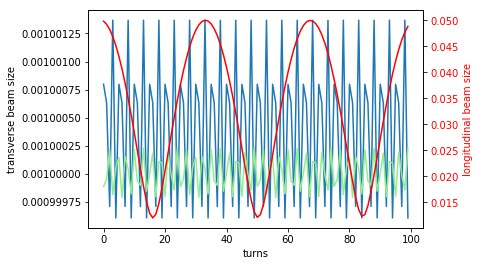

In [18]:
plt.plot(sigma_x)
plt.plot(sigma_y, color='lightgreen')
plt.xlabel('turns')
plt.ylabel('transverse beam size')
plt.twinx()
plt.plot(sigma_z, color='red')
for l in plt.gca().get_yticklabels():
    l.set_color('red')
plt.ylabel('longitudinal beam size', color='red');

### II. 2. Tracking with wakefields

In [19]:
slicer = Slicer(n_slices=500, z_min=-1, z_max=1)

resonator = BroadBandResonator(slicer, R_shunt=7e6, frequency=1.3e9, Q=1)

In [20]:
beam = get_beam()

In [21]:
xp0 = beam.xp.copy()
resonator.track(beam)
xp1 = beam.xp.copy()

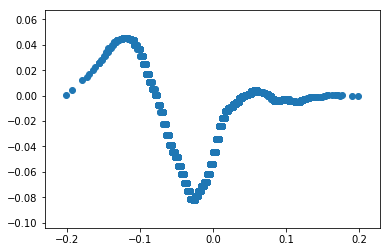

In [22]:
plt.scatter(beam.z[::100], 1e6*(xp1 - xp0)[::100])

In [23]:
one_turn_map_with_wf = one_turn_map + [resonator]

In [24]:
beam = get_beam()

In [25]:
n_turns = 100

mean_x = np.empty(n_turns, dtype=float)
mean_y = np.empty_like(mean_x)
mean_z = np.empty_like(mean_x)

with CPU(beam):
    # TRACKING!
    for turn in range(n_turns):
        for el in one_turn_map_with_wf:
            el.track(beam)
            mean_x[turn] = beam.mean_x()
            mean_y[turn] = beam.mean_y()
            mean_z[turn] = beam.mean_z()

Text(0,0.5,'longitudinal centroid')

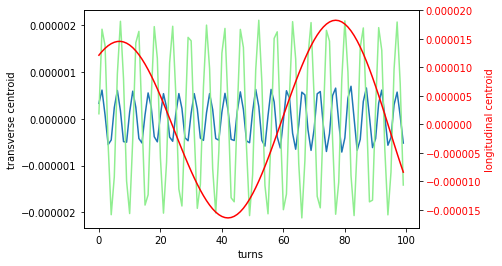

In [26]:
plt.plot(mean_x)
plt.plot(mean_y, color='lightgreen')
plt.xlabel('turns')
plt.ylabel('transverse centroid')
plt.twinx()
plt.plot(mean_z, color='red')
for l in plt.gca().get_yticklabels():
    l.set_color('red')
plt.ylabel('longitudinal centroid', color='red')

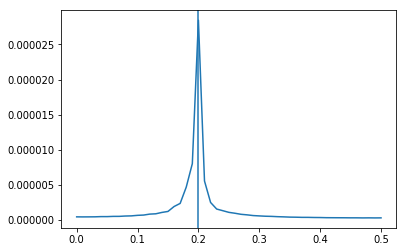

In [27]:
plt.plot(np.fft.rfftfreq(len(mean_x)), np.abs(np.fft.rfft(mean_x)))
plt.axvline(Q_x % 1)

## III. Some profiling of such a wakefield simulation

In [28]:
%load_ext line_profiler

In [29]:
def track_one_turn():
    for el in one_turn_map_with_wf:
        el.track(beam)

In [30]:
routput = %%prun -r track_one_turn()

In [31]:
routput.sort_stats(2).print_stats(40)

         3635 function calls in 0.916 seconds

   Ordered by: cumulative time
   List reduced from 68 to 40 due to restriction <40>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.916    0.916 <string>:1(<module>)
        1    0.000    0.000    0.916    0.916 <ipython-input-29-544209456374>:1(track_one_turn)
        2    0.435    0.217    0.435    0.217 <ipython-input-7-911eec8ec44b>:48(track)
        1    0.026    0.026    0.344    0.344 <ipython-input-9-f2a126cf6ed5>:19(track)
        1    0.000    0.000    0.298    0.298 <ipython-input-8-91ab3c133b54>:37(slice)
        1    0.112    0.112    0.184    0.184 <ipython-input-8-91ab3c133b54>:59(compute_means)
        1    0.137    0.137    0.137    0.137 <ipython-input-6-1931593b0407>:13(track)
        1    0.000    0.000    0.084    0.084 histograms.py:597(histogram)
       16    0.000    0.000    0.084    0.005 fromnumeric.py:760(sort)
       16    0.082    0.005    0.082    0.0

<pstats.Stats instance at 0x7f597c720a70>

In [32]:
lproutput = %%lprun -r -f Slicer.slice track_one_turn()

In [33]:
lproutput.print_stats()

Timer unit: 1e-06 s

Total time: 0.43577 s
File: <ipython-input-8-91ab3c133b54>
Function: slice at line 37

Line #      Hits         Time  Per Hit   % Time  Line Contents
    37                                               def slice(self, beam):
    38                                                   '''Factory method for SliceSets, computing discretisation and
    39                                                   statistics.
    40                                                   '''
    41         1        168.0    168.0      0.0          z_bins = pm.linspace(self.z_min, self.z_max, self.n_slices + 1)
    42         1     146559.0 146559.0     33.6          hist, _ = pm.histogram(beam.z, bins=z_bins) # _ == z_bins
    43         1      16459.0  16459.0      3.8          ids = self.particles_to_slices(beam)
    44         1     272573.0 272573.0     62.5          mean_x, mean_y = self.compute_means(ids, beam.x, beam.y)
    45         1          2.0      2.0      0.0          ret

$\implies$ the biggest part of the time is spent on computing the slice statistics for this rather ignorant and straight forward `numpy` based implementation...

## IV. Some approaches to speed up

### IV. 1. Using cython for statistics functions -- as implemented in real PyHEADTAIL

The statistics functions are typically called quite often and run much faster on the CPU by using `Cython`.

Let's implement the whole distribution statistics first to demonstrate the principle:

In [34]:
%load_ext Cython

#### a. Entire beam statistics

In [35]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp -n cython_functions
import numpy as np
cimport numpy as np
cimport libc.math as cmath

cimport cython.boundscheck
cimport cython.cdivision
cimport cython.wraparound

@cython.boundscheck(False)
@cython.cdivision(True)
cpdef double cov(double[::1] a, double[::1] b):
    cdef unsigned int n = a.shape[0]
    if n < 2:
        return 0.
    cdef double shift_a = a[0]
    cdef double shift_b = b[0]
    cdef double a_sum = 0.
    cdef double b_sum = 0.
    cdef double ab_sum = 0.
    cdef unsigned int i
    for i in xrange(n):
        a_sum += a[i] - shift_a
        b_sum += b[i] - shift_b
        ab_sum += (a[i] - shift_a) * (b[i] - shift_b)
    return (ab_sum - a_sum * b_sum / n) / (n - 1)


@cython.boundscheck(False)
@cython.cdivision(True)
cpdef double std(double[::1] u):
    return cmath.sqrt(cov(u, u))


@cython.boundscheck(False)
@cython.cdivision(True)
cpdef double emittance_geo(double[::1] u, double[::1] up):
    covariance = cov
    cdef double sigma11 = 0.
    cdef double sigma12 = 0.
    cdef double sigma22 = 0.
    cdef double cov_u2 = covariance(u, u)
    cdef double cov_up2 = covariance(up, up)
    cdef double cov_u_up = covariance(up, u)
    cdef double cov_u_dp = 0.
    cdef double cov_up_dp = 0.
    cdef double cov_dp2 = 1.

    sigma11 = cov_u2
    sigma12 = cov_u_up
    sigma22 = cov_up2

    return cmath.sqrt(sigma11 * sigma22 - sigma12 * sigma12)

So let's make use of the just cythonised statistics functions and define a context manager using them:

In [36]:
import cython_functions

cython_dict = cpu_dict.copy()
cython_dict.update(dict(
    cov=cython_functions.cov,
    std=cython_functions.std,
    emittance_geo=cython_functions.emittance_geo,
))

In [37]:
class CPU_Cython(CPU):
    '''CPU context manager working with the numpy library
    and some cythonised functions for the beam statistics.
    '''
    def __enter__(self):
        # moving data to device
        for attr in self.to_move:
            coord = getattr(self.beam, attr)
            transferred = np.asarray(coord)
            setattr(self.beam, attr, transferred)

        # replace functions in general.math.py
        pm.update_active_dict(cython_dict)
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        # here should be moving data back to host
        pm.update_active_dict(pm._default_function_dict)

So what does the timing say in comparison?

In [38]:
%%timeit 
with CPU(beam):
    beam.sigma_x()

10 loops, best of 3: 104 ms per loop


In [39]:
%%timeit 
with CPU_Cython(beam):
    beam.sigma_x()

1000 loops, best of 3: 1.4 ms per loop


$\implies 5\times$ speed-up with Cython for beam size evaluation

In [40]:
%%timeit 
with CPU(beam):
    beam.epsn_x()

The slowest run took 4.61 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 3: 37 ms per loop


In [41]:
%%timeit 
with CPU_Cython(beam):
    beam.epsn_x()

100 loops, best of 3: 4.44 ms per loop


$\implies 1.5\times$ speed-up with Cython for emittance evaluation

#### b. Slice statistics can be implemented the same way

(...) to be implemented

### IV. 2. Graphics Processing Unit acceleration: using `cupy` 

The only function missing in `cupy` to cover all cpu_dict implemented functions is `pm.convolve`. We implement it by going via Fourier space: $a * b = \mathcal{F}^{-1}\bigl(\mathcal{F}(a)\cdot\mathcal{F}(b)\bigr)$

In [42]:
def convolve_via_fft(a, b):
    if len(b) < len(a):
        a, b = b, a
    a_padded = pm.zeros(len(b), dtype=np.float64)
    # rolled by 1 in order to reproduce np.convolve(mode='valid'):
    a_padded[-len(a)+1:] = a[:-1]
    a_padded[0] = a[-1] 
    f1 = pm.fft(a_padded)
    f2 = pm.fft(b)
    conv = pm.ifft(f1 * f2)
    conv = pm.real(conv) # throw away imaginary part (numerical fluctuations around 0)
    return conv[:len(a)]

Implementation of the context management based on `cupy`:

In [43]:
import cupy

# references to all relevant methods on GPU via cupy
cupy_dict = dict(
    sin=cupy.sin,
    cos=cupy.cos,
    tan=cupy.tan,
    exp=cupy.exp,
    sinh=cupy.sinh,
    cosh=cupy.cosh,
    tanh=cupy.tanh,
    sqrt=cupy.sqrt,
    abs=cupy.abs,
    floor=cupy.floor,
    real=cupy.real,
    imag=cupy.imag,
    fft=cupy.fft.fft,
    ifft=cupy.fft.ifft,
    # voila:
    convolve=convolve_via_fft,
    
    histogram=cupy.histogram,
    mean=cupy.mean,
    cov=lambda a, b: cupy.cov(a, b)[0, 1],
    std=lambda u: cupy.sqrt(cupy_dict['cov'](u, u)),
    emittance_geo=lambda u, up: cupy.sqrt(cupy.linalg.det(cupy.cov(u, up))),
    asarray=cupy.asarray,
    empty=cupy.empty,
    zeros=cupy.zeros,
    linspace=cupy.linspace,
    arange=cupy.arange,
    take=cupy.take,
    where=cupy.where,
    concatenate=cupy.concatenate,
    clip=cupy.clip,
)

class GPU_cupy(object):
    '''GPU context manager working with the cupy library.
    '''
    
    def __init__(self, beam):
        self.beam = beam
        self.to_move = beam.coords_n_momenta

    def __enter__(self):
        # moving data to device
        for attr in self.to_move:
            coord = getattr(self.beam, attr)
            transferred = cupy.asarray(coord)
            setattr(self.beam, attr, transferred)

        # replace functions in general.math.py
        pm.update_active_dict(cupy_dict)
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        # moving data back to host
        for attr in self.to_move:
            coord = getattr(self.beam, attr)
            transferred = coord.get()
            setattr(self.beam, attr, transferred)
        pm.update_active_dict(pm._default_function_dict)

#### Sanity check for convolve function

Let's check on the beam:

In [44]:
s = slicer.slice(beam)

a = s.mean_x * s.n_macroparticles_per_slice

dt = (s.z_bins[:-1] + np.diff(s.z_bins) / 2) / (beam.beta * c)
dt_to = pm.concatenate((dt - dt[-1], (dt - dt[0])[1:]))

wf = resonator.wake_function(dt_to)

(-2e-09, 1e-09)

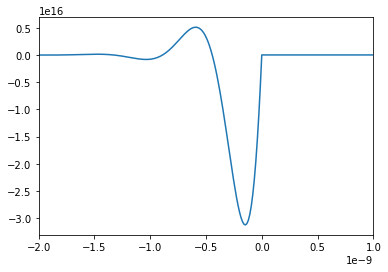

In [45]:
# wakefield as Green's function:
plt.plot(dt_to, wf)
plt.xlim(-2e-9, 1e-9)

With `numpy` this works fine:

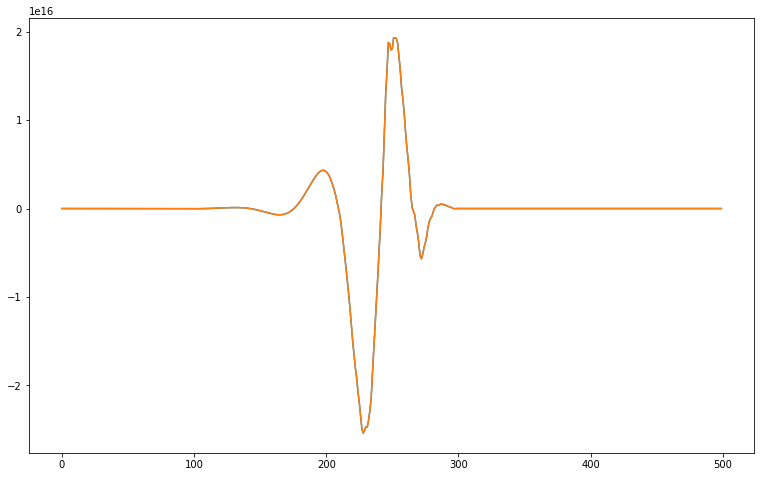

In [46]:
plt.figure(figsize=(13, 8))
plt.plot(convolve_via_fft(a, wf))
plt.plot(pm.convolve(a, wf))

And also with `cupy` on the GPU:

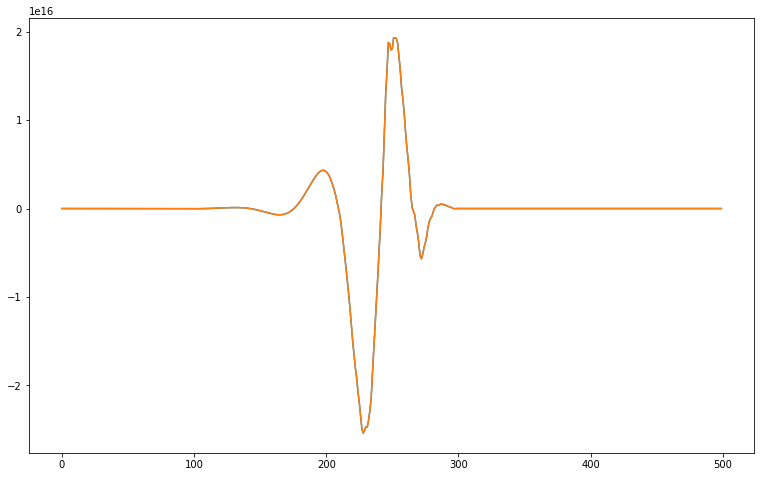

In [47]:
plt.figure(figsize=(13, 8))
with GPU_cupy(beam):
    try:
        a = cupy.asarray(a)
        wf = cupy.asarray(wf)
        plt.plot(convolve_via_fft(a, wf).get())
        plt.plot(pm.convolve(a, wf).get())
    finally:
        a = a.get()
        wf = wf.get()

$\implies$ both the blue and orange curve give the same convolution, for both CPU and GPU FFT implementation (`numpy` and `cupy`), i.e. everything is fine -- `convolve_via_fft` does the same as `np.convolve(mode='valid')`, which is the one we use in PyHEADTAIL.

#### Let's run a simulation with `cupy`:

In [48]:
beam = get_beam()

In [49]:
n_turns = 100

mean_x = np.empty(n_turns, dtype=float)
mean_y = np.empty_like(mean_x)
mean_z = np.empty_like(mean_x)

with GPU_cupy(beam):
    # TRACKING!
    for turn in range(n_turns):
        for el in one_turn_map_with_wf:
            el.track(beam)
            mean_x[turn] = beam.mean_x().get()
            mean_y[turn] = beam.mean_y().get()
            mean_z[turn] = beam.mean_z().get()

Text(0,0.5,'longitudinal centroid')

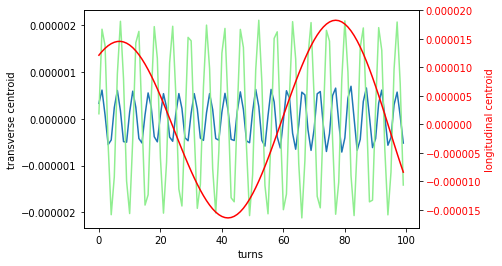

In [50]:
plt.plot(mean_x)
plt.plot(mean_y, color='lightgreen')
plt.xlabel('turns')
plt.ylabel('transverse centroid')
plt.twinx()
plt.plot(mean_z, color='red')
for l in plt.gca().get_yticklabels():
    l.set_color('red')
plt.ylabel('longitudinal centroid', color='red')

#### Profile it!

In [51]:
with GPU_cupy(beam):
    routput = %%prun -r track_one_turn()

In [52]:
routput.sort_stats(2).print_stats(40)

         8869 function calls in 0.308 seconds

   Ordered by: cumulative time
   List reduced from 97 to 40 due to restriction <40>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.308    0.308 <string>:1(<module>)
        1    0.000    0.000    0.308    0.308 <ipython-input-29-544209456374>:1(track_one_turn)
        1    0.000    0.000    0.306    0.306 <ipython-input-9-f2a126cf6ed5>:19(track)
        1    0.000    0.000    0.288    0.288 <ipython-input-8-91ab3c133b54>:37(slice)
        1    0.032    0.032    0.285    0.285 <ipython-input-8-91ab3c133b54>:59(compute_means)
      505    0.001    0.000    0.217    0.000 fusion.py:842(call)
      502    0.001    0.000    0.215    0.000 search.py:107(where)
      502    0.001    0.000    0.214    0.000 search.py:58(nonzero)
      502    0.212    0.000    0.214    0.000 {method 'nonzero' of 'cupy.core.core.ndarray' objects}
      500    0.029    0.000    0.030    0.000 {any}
        2

<pstats.Stats instance at 0x7f597b66bf38>

In [53]:
with GPU_cupy(beam):
    lproutput = %%lprun -r -f Slicer.slice track_one_turn()

In [54]:
lproutput.print_stats()

Timer unit: 1e-06 s

Total time: 0.165395 s
File: <ipython-input-8-91ab3c133b54>
Function: slice at line 37

Line #      Hits         Time  Per Hit   % Time  Line Contents
    37                                               def slice(self, beam):
    38                                                   '''Factory method for SliceSets, computing discretisation and
    39                                                   statistics.
    40                                                   '''
    41         1        114.0    114.0      0.1          z_bins = pm.linspace(self.z_min, self.z_max, self.n_slices + 1)
    42         1       2652.0   2652.0      1.6          hist, _ = pm.histogram(beam.z, bins=z_bins) # _ == z_bins
    43         1        176.0    176.0      0.1          ids = self.particles_to_slices(beam)
    44         1     162441.0 162441.0     98.2          mean_x, mean_y = self.compute_means(ids, beam.x, beam.y)
    45         1          1.0      1.0      0.0          re

### Summary

`cupy` can be incorporated within the context management system and let's `PyHEADTAIL` compute on the GPU. The current longitudinal discretisation implemented in the `Slicer` class could be sped up significantly e.g. by sorting the particles longitudinally and base the `pm.histogram` and slice statistics on this.

### IV. 3. Graphics Processing Unit acceleration: using `PyCUDA` 

In [55]:
import pycuda.autoinit
import pycuda.gpuarray as gp

In [56]:
from pycuda import cumath

In [57]:
from pycuda.compiler import SourceModule
from pycuda.elementwise import ElementwiseKernel

### histogram kernel

The histogram function is missing in `pycuda`. We implement it as an `ElementwiseKernel`.

In [58]:
hist_pycuda_kernel = ElementwiseKernel(
    "double *z, double *zbins, const int nslices, int *histogram",
    
    """
    int j = 0;
    if (z[i] >= zbins[0] || z[i] < zbins[nslices - 1]) {
        while (z[i] >= zbins[j]){
            j++;
        }
        atomicAdd(&histogram[j-1], 1);
    }
    """
)

In [59]:
def hist_pycuda(x, bins):
    n_bins = np.int32(len(bins) - 1)
    out = gp.zeros(n_bins, dtype=np.int32)
    hist_pycuda_kernel(x, bins, n_bins, out)
    return out, bins

#### Sanity check for histogram function

Let's check on the beam:

In [60]:
dz = (slicer.z_max - slicer.z_min) / float(slicer.n_slices)
z_bins = gp.arange(slicer.z_min, slicer.z_max + dz * 0.1, dz, dtype=float)

out, _ = hist_pycuda(gp.to_gpu(beam.z), z_bins);

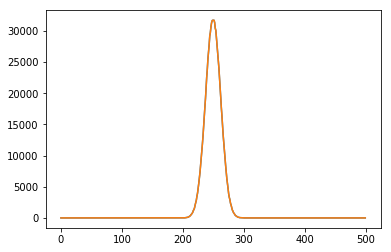

In [61]:
plt.plot(out.get()) #- np.histogram(beam.z, bins=z_bins.get())[0])
plt.plot(np.histogram(beam.z, bins=z_bins.get())[0])

### convolution function

In [62]:
convolution_mod = SourceModule('''
__global__ void conv1D(
        // input arrays
        double* __restrict__ A, double* __restrict__ B, 
        // input array lengths
        const int N, const int P,
        // output
        double* C)
{
    for (int idx = blockIdx.x * blockDim.x + threadIdx.x; 
         idx < N; 
         idx += blockDim.x * gridDim.x)
        {
            int i = idx;
            int radius = (P - 1) / 2;
            if ((i >= radius) && (i < (N-1 - radius))){
              double sum = 0;
              for (int j = -radius; j <= radius; j++)
                sum += A[i+j] * B[j+radius];
              C[i-radius] = sum;
        }
    }
}''')

convolve_pycuda_kernel = convolution_mod.get_function('conv1D')

convolve_pycuda_kernel.prepare('PPiiP')

In [63]:
def idivup(a, b):
    ''' Compute int(a)//int(b) and round up to next integer if a%b != 0 '''
    a = np.int32(a)
    b = np.int32(b)
    z = (a // b + 1) if (a % b != 0) else (a // b)
    return int(z)

In [64]:
def convolve_pycuda(a, b):
    '''Same as np.convolve with mode=\'valid\' '''
    assert (isinstance(a, gp.GPUArray) and isinstance(b, gp.GPUArray), 
            'Require PyCUDA GPUArray instances as args')
    assert (a.dtype == b.dtype == np.float64)
    if b.size > a.size:
        a, b = b, a
    c = gp.empty(a.size - b.size + 1, dtype=np.float64)
    convolve_pycuda_kernel.prepared_call(
#         (idivup(a.size, 256), 1, 1), (256, 1, 1), 
        (1, 1, 1), (100, 1, 1),
        a.gpudata, b.gpudata, np.int32(a.size), np.int32(b.size), c.gpudata
    )
    return c

<ipython-input-64-d5bdfaa4f8e9>:3: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (isinstance(a, gp.GPUArray) and isinstance(b, gp.GPUArray),


In [65]:
np.convolve(np.arange(100, dtype=float), np.arange(-100, 0, dtype=float), mode='valid')

array([-333300.])

In [66]:
convolve_pycuda(gp.arange(100, dtype=float), gp.arange(-100,0, dtype=float))

array([-166551.])

In [ ]:
!!!!

In [67]:
# references to all relevant methods on GPU via pycuda modules
pycuda_dict = dict(
    sin=cumath.sin,
    cos=cumath.cos,
    tan=cumath.tan,
    exp=cumath.exp,
    sinh=cumath.sinh,
    cosh=cumath.cosh,
    tanh=cumath.tanh,
    sqrt=cumath.sqrt,
    abs=lambda array: array.__abs__(),
    floor=cumath.floor,
    real=lambda array: array.real,
    imag=lambda array: array.imag,
#     fft=.fft.fft,
#     ifft=.fft.ifft,
    
    convolve=convolve_pycuda,
    
    histogram=hist_pycuda,
    mean=lambda array: gp.sum(array)/len(array),
    cov=lambda a, b: cumath.cov(a, b)[0, 1],
    std=lambda u: cumath.sqrt(pycuda_dict['cov'](u, u)),
    emittance_geo=lambda u, up: cumath.sqrt(cumath.linalg.det(cumath.cov(u, up))),
    asarray=lambda obj: gp.to_gpu(np.array(obj)),
    empty=gp.empty,
    zeros=gp.zeros,
    linspace=lambda *args, **kwargs: gp.to_gpu(np.linspace(*args, **kwargs)),
    arange=gp.arange,
    take=gp.take,
#     where=gp.where,
#     concatenate=gp.concatenate,
#     clip=gp.clip,
)

class GPU_pycuda(object):
    '''GPU context manager working with the pycuda library.
    '''
    
    def __init__(self, beam):
        self.beam = beam
        self.to_move = beam.coords_n_momenta

    def __enter__(self):
        # moving data to device
        for attr in self.to_move:
            coord = getattr(self.beam, attr)
            transferred = gp.to_gpu(coord)
            setattr(self.beam, attr, transferred)

        # replace functions in general.math.py
        pm.update_active_dict(pycuda_dict)
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        # moving data back to host
        for attr in self.to_move:
            coord = getattr(self.beam, attr)
            transferred = coord.get()
            setattr(self.beam, attr, transferred)
        pm.update_active_dict(pm._default_function_dict)

In [68]:
s = slicer.slice(beam)

a = s.mean_x * s.n_macroparticles_per_slice

dt = (s.z_bins[:-1] + np.diff(s.z_bins) / 2) / (beam.beta * c)
dt_to = pm.concatenate((dt - dt[-1], (dt - dt[0])[1:]))

wf = resonator.wake_function(dt_to)

(-2e-09, 1e-09)

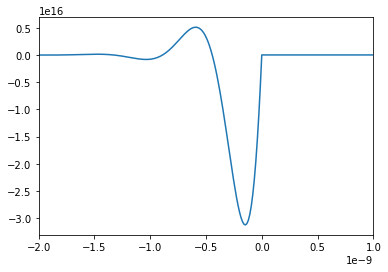

In [69]:
# wakefield as Green's function:
plt.plot(dt_to, wf)
plt.xlim(-2e-9, 1e-9)

With `numpy` this works fine:

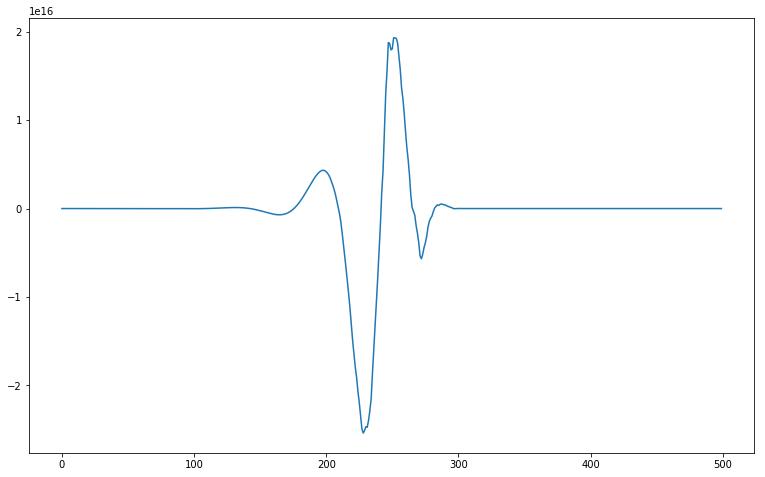

In [70]:
plt.figure(figsize=(13, 8))
plt.plot(pm.convolve(a, wf))

plt.plot(convolve_pycuda(gp.to_gpu(pm.concatenate((a, pm.zeros(wf.size - a.size)))), gp.to_gpu(wf)).get())

### Let's run a basic tracking simulation with `pycuda`:

In [71]:
beam = get_beam()

In [72]:
n_turns = 100

mean_x = np.empty(n_turns, dtype=float)
mean_y = np.empty_like(mean_x)
mean_z = np.empty_like(mean_x)

with GPU_pycuda(beam):
    # TRACKING!
    for turn in range(n_turns):
        for el in one_turn_map:
            el.track(beam)
            mean_x[turn] = beam.mean_x().get()
            mean_y[turn] = beam.mean_y().get()
            mean_z[turn] = beam.mean_z().get()

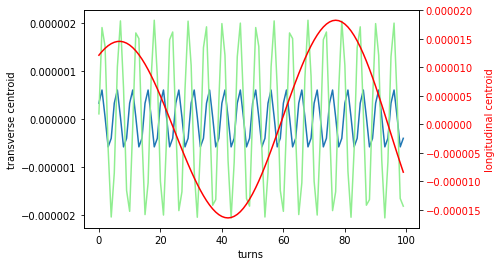

In [73]:
plt.plot(mean_x)
plt.plot(mean_y, color='lightgreen')
plt.xlabel('turns')
plt.ylabel('transverse centroid')
plt.twinx()
plt.plot(mean_z, color='red')
for l in plt.gca().get_yticklabels():
    l.set_color('red')
plt.ylabel('longitudinal centroid', color='red');

#### Now let's run a wakefield simulation with `pycuda`:

In [74]:
beam = get_beam()

In [75]:
n_turns = 100

mean_x = np.empty(n_turns, dtype=float)
mean_y = np.empty_like(mean_x)
mean_z = np.empty_like(mean_x)

with GPU_pycuda(beam):
    # TRACKING!
    for turn in range(n_turns):
        for el in one_turn_map_with_wf:
            el.track(beam)
            mean_x[turn] = beam.mean_x().get()
            mean_y[turn] = beam.mean_y().get()
            mean_z[turn] = beam.mean_z().get()

TypeError: an integer is required

## `CuPy` memory handling

In [2]:
from pycuda import gpuarray as gp

In [3]:
a = gp.arange(100, dtype=float)

In [4]:
from cupy.cuda.memory import UnownedMemory, MemoryPointer

In [7]:
# device_id = 3

In [5]:
mem = UnownedMemory(ptr=a.gpudata, size=a.size, owner=a)#, device_id=device_id)

In [6]:
memptr = MemoryPointer(mem, offset=0)

In [7]:
b = cupy.ndarray(a.shape, dtype=a.dtype, memptr=memptr)

In [8]:
b

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.,
       91., 92., 93., 94., 95., 96., 97., 98., 99.])

In [9]:
b[0] -= 42

In [10]:
a[0] == -42

array(1.)

## `PyCUDA` memory handling

In [11]:
a = cupy.arange(100, dtype=float)

In [12]:
a.data.ptr

140157281894912

In [13]:
b = gp.GPUArray(a.shape, dtype=a.dtype, gpudata=a.data.ptr)

In [14]:
type(b)

pycuda.gpuarray.GPUArray

In [21]:
b[0] += -42

In [22]:
a[0] == -42

array(True)